## Introduction
Learning how to create models with yml files


## Setup

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml
from pymc_marketing.paths import data_dir

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/pablo.deroqueglovoapp.com/pymc-labs/pymc-marketing/pymc_marketing/mmm/multidimensional.py:78: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/var/folders/7q/tb5r85wd19l3fplnxjyfdn7r0000gp/T/ipykernel_44888/1583561548.py:7: UserWarning: The pymc_marketing.mmm.builders module is experimental and its API may change without warning.
  from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml


In [2]:
X = pd.read_csv(data_dir / "processed" / "X.csv")
y = pd.read_csv(data_dir / "processed" / "y.csv")

In [3]:
X.head(3)

,date,market,channel_1,channel_2
0,2023-01-01,US,70.171496,20.945956
1,2023-01-02,US,90.243918,45.828916
2,2023-01-03,US,9.178717,26.322735


In [4]:
y.head(3)

,y
0,45.453806
1,42.516346
2,54.250939


## Multidimensional model

In [5]:
mmm = build_mmm_from_yaml(
    X=X, y=y, config_path=data_dir / "config_files" / "multi_dimensional_model.yml"
)

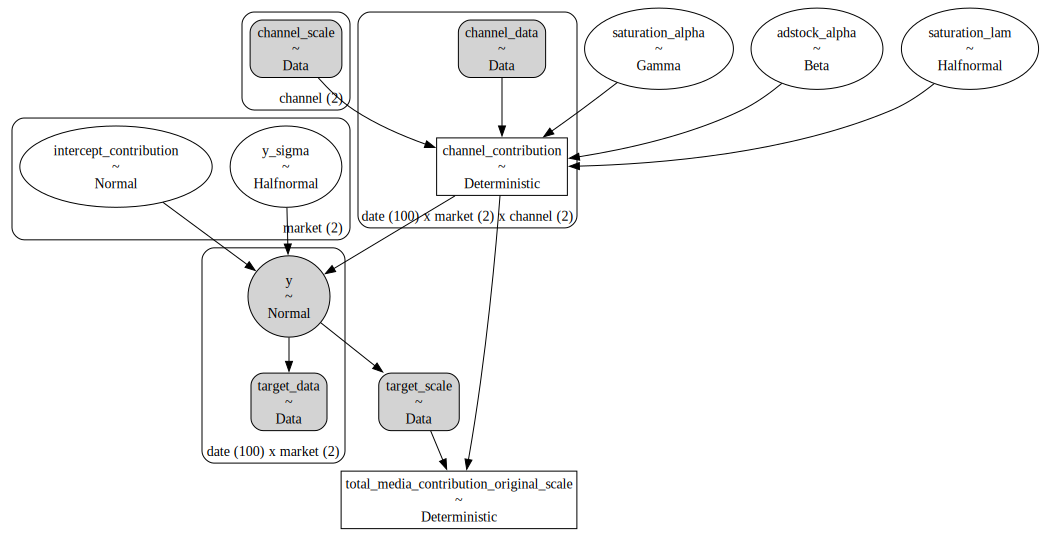

In [10]:
mmm.model.to_graphviz()

In [11]:
prior_predictive = mmm.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, intercept_contribution, saturation_alpha, saturation_lam, y, y_sigma]


In [12]:
prior_predictive

<xarray.Dataset> Size: 2MB
Dimensions:  (date: 100, market: 2, sample: 1000)
Coordinates:
  * date     (date) datetime64[ns] 800B 2023-01-01 2023-01-02 ... 2023-04-10
  * market   (market) <U2 16B 'EU' 'US'
  * sample   (sample) object 8kB MultiIndex
  * chain    (sample) int64 8kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, market, sample) float64 2MB -0.4204 -0.5143 ... -0.4165
Attributes:
    created_at:                 2025-08-20T19:37:41.813116+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.15.1

In [13]:
mmm.fit(
    X=X,
    y=y.y,
    random_seed=42,
)

mmm.sample_posterior_predictive(
    X=X,
    extend_idata=True,
    combined=True,
    random_seed=42,
)

PicklingError: Can't pickle <built-in function input>: it's not the same object as builtins.input

### How the config works?

In [20]:
# Let's look at the content of the basic model configuration file
with open(data_dir / "config_files" / "basic_model.yml") as f:
    basic_config = f.read()

print(basic_config)

model:
  class: pymc_marketing.mmm.multidimensional.MMM
  kwargs:
    date_column: "date"
    channel_columns:                                     # explicit for reproducibility
      - channel_1
      - channel_2
      # …
    target_column: "y"

    # --- media transformations ---------------------------------------
    adstock:
      class: pymc_marketing.mmm.GeometricAdstock
      kwargs: {l_max: 12}        # any other hyper-parameters here

    saturation:
      class: pymc_marketing.mmm.MichaelisMentenSaturation
      kwargs: {}                 # default α, λ priors inside the class

# ----------------------------------------------------------------------
# (optional) sampler options you plan to forward to pm.sample():
    sampler_config:
      tune: 1000
      draws: 200
      chains: 8
      random_seed: 42
      target_accept: 0.90
      nuts_sampler: "nutpie"

# ----------------------------------------------------------------------
# (optional) idata from a previous sample
# 

The configuration file uses a structured YAML format with several key sections:
1. schema_version: Version identifier for the configuration schema
2. model: The main model configuration
   - class: The Python class to instantiate (fully qualified name)
   - kwargs: Arguments passed to the model constructor
     - Including data columns, transformations (adstock, saturation)
3. sample_kwargs: Optional parameters for the sampling process
4. data: Optional paths to data files

The build_mmm_from_yaml function:
- Parses this YAML configuration
- Uses the 'build' function to instantiate objects recursively
- Handles special cases like priors and distributions
- Returns a fully configured MMM model ready for sampling
- If idata_path is provided then the idata from a previous class is used in the model in the idata property.

## Basic model

In [ ]:
mmm2 = build_mmm_from_yaml(
    X=X, y=y, config_path=data_dir / "config_files" / "basic_model.yml"
)

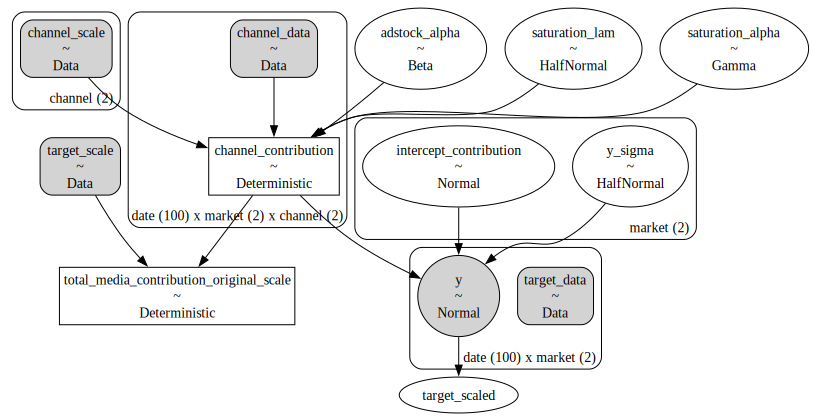

In [22]:
mmm2.model.to_graphviz()

In [23]:
prior_predictive = mmm2.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, intercept_contribution, saturation_alpha, saturation_lam, y, y_sigma]


## Multidimensional Hierarchical Model

In [24]:
mmm3 = build_mmm_from_yaml(
    X=X,
    y=y,
    config_path=data_dir / "config_files" / "multi_dimensional_hierarchical_model.yml",
)

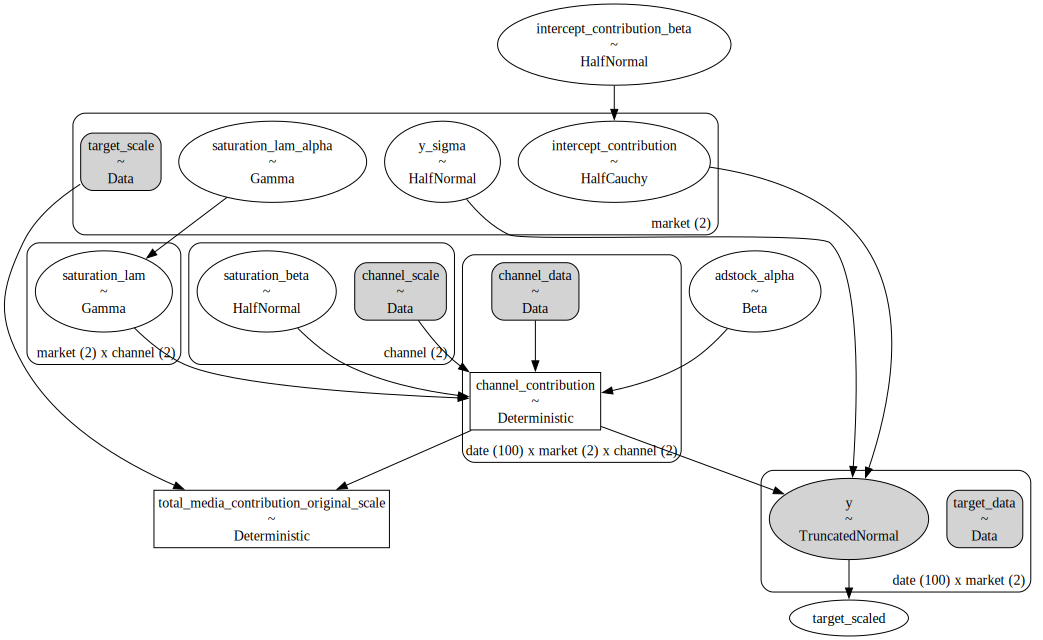

In [25]:
mmm3.model.to_graphviz()

In [26]:
prior_predictive = mmm3.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, intercept_contribution, intercept_contribution_beta, saturation_beta, saturation_lam, saturation_lam_alpha, y, y_sigma]


## Multidimensional Hierarchical with arbitrary effects

In [27]:
mmm4 = build_mmm_from_yaml(
    X=X,
    y=y,
    config_path=data_dir
    / "config_files"
    / "multi_dimensional_hierarchical_with_arbitrary_effects_model.yml",
)

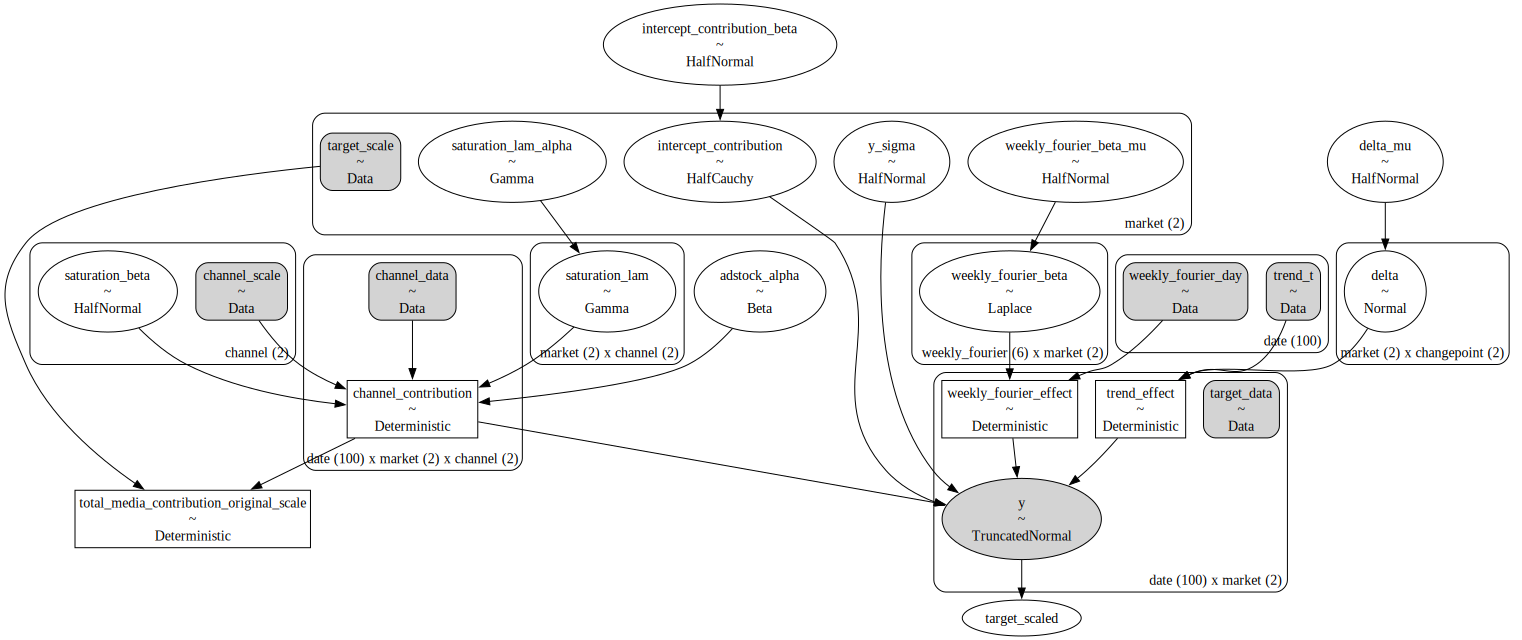

In [28]:
mmm4.model.to_graphviz()

In [29]:
prior_predictive = mmm4.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, delta, delta_mu, intercept_contribution, intercept_contribution_beta, saturation_beta, saturation_lam, saturation_lam_alpha, weekly_fourier_beta, weekly_fourier_beta_mu, y, y_sigma]
